# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
n_samples = 1000
n_features = 100
seed = 1

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, random_state=seed, noise=1.0, effective_rank=100)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    pass

In [6]:
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

## SciKit-Learn SGD

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
n_iter = 10000

In [9]:
sgd = SGDRegressor(n_iter=n_iter)

In [10]:
%time sgd.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 5.08 ms, total: 2.3 s
Wall time: 2.29 s


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=10000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [11]:
sgd.score(X_test, y_test)

0.83271972290526819

In [12]:
scores = []
sgd = SGDRegressor(n_iter=1, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores += [sgd.score(X_test, y_test)]

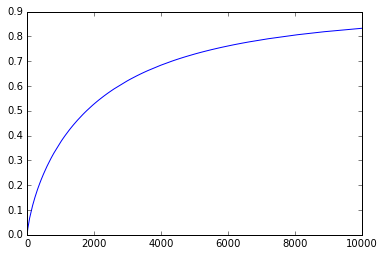

In [13]:
plt.plot(range(len(scores)), scores)

In [14]:
scores[-1]

0.83271100545502186

##  Parallel SGD
**Work in progress.**  

### Test 1: Split data evenly, synchronize at the end
Simulate running SGD in parallel such that the input data is split evenly amongst the workers. The weights are synchronized once after all workers are done.

In [16]:
def parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job, overlap=False):
    
    print "Spliting data..."
    
    if overlap:
        data_size = len(X_train)
        splits = [np.random.choice(data_size, size=int(split_per_job*data_size), replace=False) for _ in range(n_jobs)]
        data = zip([X_train[split] for split in splits], [y_train[split] for split in splits])
    else:
        if split_per_job!=1/n_jobs:
            raise Exception("split_per_job must be equal to 1/n_jobs")
        data = zip(np.split(X_train, n_jobs), np.split(y_train, n_jobs))


    # Execute in parallel
    print "Executing %d jobs" % n_jobs
    
    scores = []
    
    sgds =[]
    for n in range(n_jobs):
        sgds += [SGDRegressor(n_iter=1, warm_start=True)]

    for i in range(n_iter):
        iter_scores = []
        iter_coefs = []
        iter_intercepts = []
        
        for n, sgd in enumerate(sgds):
            sgd.partial_fit(data[n][0], data[n][1])
#             sgd.fit(X_train, y_train)
            iter_scores += [sgd.score(X_test, y_test)]
            iter_coefs += [sgd.coef_]
            iter_intercepts += [sgd.intercept_]
        
        iter_coefs = np.mean(np.array(iter_coefs), axis=0)
        iter_intercepts = np.mean(np.array(iter_intercepts), axis=0)
        
        sgd = SGDRegressor()
        sgd.coef_ = iter_coefs
        sgd.intercept_ = iter_intercepts
        iter_scores += [sgd.score(X_test, y_test)]
        
        scores += [iter_scores]
        
    return scores

In [26]:
n_jobs = 4

scores = parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

Spliting data...
Executing 4 jobs


In [27]:
scores = np.array(scores).T

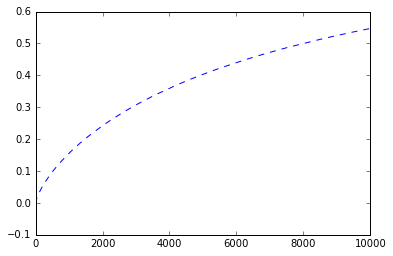

In [28]:
# for s in scores[:-1]:
#     plt.figure(1)
#     plt.plot(range(len(s)), s)
plt.figure(1)
plt.plot(range(len(scores[-1])), scores[-1], '--')

### Test 2: Don't Split data, synchronize at the end
Simulate running SGD in parallel such that all workers have access to all the data. The weights are synchronized once after all workers are done.


In [29]:
n_jobs = 4
scores = parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True)

Spliting data...
Executing 4 jobs


In [30]:
scores = np.array(scores).T

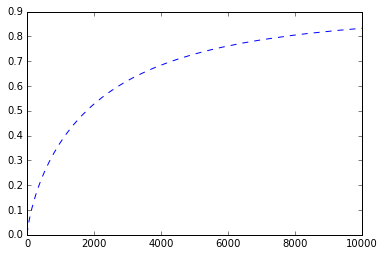

In [31]:
# for s in scores[:-1]:
#     plt.figure(1)
#     plt.plot(range(len(s)), s)
plt.figure(1)
plt.plot(range(len(scores[-1])), scores[-1], '--')

### Test 3: Split data with overlap, synchronize at the end

In [32]:
n_jobs = 4
scores = parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

Spliting data...
Executing 4 jobs


In [33]:
scores = np.array(scores).T

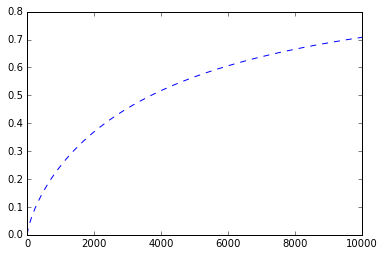

In [34]:
# for s in scores[:-1]:
#     plt.figure(1)
#     plt.plot(range(len(s)), s)
plt.figure(1)
plt.plot(range(len(scores[-1])), scores[-1], '--')

In [35]:
n_jobs = 4
scores = parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

Spliting data...
Executing 4 jobs


In [36]:
scores = np.array(scores).T

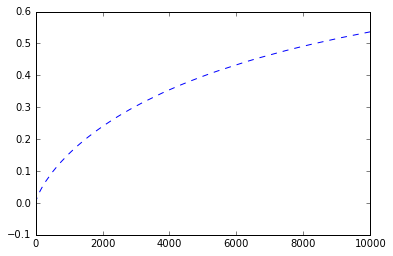

In [37]:
# for s in scores[:-1]:
#     plt.figure(1)
#     plt.plot(range(len(s)), s)
plt.figure(1)
plt.plot(range(len(scores[-1])), scores[-1], '--')

### Test 4: Split data with overlap, synchronize 2 times
**Pending**

### Hacky parallel SGD

In [ ]:
from multiprocessing import Pool

In [ ]:
import numpy as np

In [ ]:
def psgd_method(args):
    X_train, y_train, n_iter = args
    sgd = SGDRegressor(n_iter=n_iter)
    sgd.fit(X_train, y_train)
    return sgd.coef_, sgd.intercept_

In [ ]:
def add_results(x, y):
    return x[0]+y[0], x[1]+y[1]

In [ ]:
def parallel_sgd(sgd, pool, X, y, n_iter, n_jobs):
    
    # Split data into n_jobs chunks
    print "Spliting data..."
    data = zip(np.split(X_train, n_jobs), 
               np.split(y_train, n_jobs), 
               [n_iter for _ in range(n_jobs)])
    
    # Execute in parallel
    print "Executing in parallel..."
    result = pool.map(psgd_method, data)
    
    # Combine results
    print "Combining results..."
#     result = reduce(add_results, result)
#     result = [x/n_jobs for x in result]
    result = np.mean(np.array(result), axis=0)
    
    # Add coefs and intercept to the sgd object
    coef, intercept = result
    sgd.coef_ = coef
    sgd.intercept_ = intercept
    
    return sgd
    

In [ ]:
n_jobs = 4

In [ ]:
pool = Pool(processes=n_jobs)

In [ ]:
%time sgd_p = parallel_sgd(SGDRegressor(), pool, X_train, y_train, n_iter, n_jobs)

In [ ]:
sgd_p.score(X_test, y_test)